## parameters

In [1]:
CLUSTER_ALGO = 'KMedoids'
C_SHAPE ='circle'
#C_SHAPE ='CIRCLE'
#C_SHAPE ='ellipse'
#N_CLUSTERS = [50,300, 1000]
N_CLUSTERS = [1000]
CLUSTERS_STD = 0.1
N_P_CLUSTERS = [5]
N_CLUSTERS_S = N_CLUSTERS[0]
INNER_FOLDS = 5
OUTER_FOLDS = 5

## includes

In [2]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons


In [3]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.5              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

## Output registry

In [4]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../../../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments/Cluster/kmeans-kmedoids', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments/Cluster/kmeans-kmedoids


'/docker/photon_experiments/Cluster/kmeans-kmedoids'

In [5]:

import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from math import floor,ceil
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
PALLET = ['#40111D', '#DCD5E4', '#E7CC74'
                 ,'#39C8C6', '#AC5583', '#D3500C'
                 ,'#FFB139', '#98ADA7', '#AD989E'
                 ,'#708090','#6C8570','#3E534D'
                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#630C3A','#F1D0AF','#64788B'                 
                 ,'#8B7764','#7A3C5D','#77648B'
                 ,'#eaff39','#39ff4e','#4e39ff'
                 ,'#ff4e39','#87ff39','#ff3987', ]
N_PALLET = len(PALLET)
sns.set_palette(PALLET)
sns.palplot(PALLET)


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
from photonai.photonlogger.logger import logger
#from photonai.base.registry.registry import PhotonRegistry

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## function defintions

In [6]:
def yield_parameters_ellipse(n_p_clusters):
    cluster_std = CLUSTERS_STD
    for n_p_cluster in n_p_clusters:
        for n_cluster in N_CLUSTERS:
            print('ncluster:', n_cluster)
            n_cluster_std = [cluster_std for k in range(n_cluster)]
            n_samples = [n_p_cluster for k in range(n_cluster)]
            data_X, data_y = make_blobs(n_samples=n_samples,
                                       cluster_std=n_cluster_std, random_state=0)
            transformation = [[0.6, -0.6], [-0.4, 0.8]]
            X_ellipse = np.dot(data_X, transformation)
            yield [X_ellipse, data_y, n_cluster]

In [7]:
def yield_parameters(n_p_clusters):
    cluster_std = CLUSTERS_STD
    for n_p_cluster in n_p_clusters:
        for n_cluster in N_CLUSTERS:
            n_cluster_std = [cluster_std for k in range(n_cluster)]
            n_samples = [n_p_cluster for k in range(n_cluster)]
            data_X, data_y = make_blobs(n_samples=n_samples,
                                       cluster_std=n_cluster_std, random_state=0)
            yield [data_X, data_y, n_cluster]

In [8]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [9]:
def cluster_plot(my_pipe, data_X, n_cluster, PALLET):
    y_pred= my_pipe.predict(data_X)
    data = pd.DataFrame(data_X[:, 0],columns=['x'])
    data['y'] = data_X[:, 1]
    data['labels'] = y_pred
    facet = sns.lmplot(data=data, x='x', y='y', hue='labels', 
                       aspect= 1.0, height=10,
               fit_reg=False, legend=True, legend_out=True)

    customPalette = PALLET*ceil((n_cluster/N_PALLET +7))
    for i, label in enumerate( np.sort(data['labels'].unique())):
        plt.annotate(label, 
                     data.loc[data['labels']==label,['x','y']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=5, weight='bold',
                     color='white',
                     backgroundcolor=customPalette[i]) 

    plt.show()
    return y_pred

In [10]:
def simple_output(string: str, number: int) -> None:
    print(string, number)
    logger.info(string, number )

In [11]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/photon_experiments/Cluster/custom_elements'

In [12]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [13]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMeans blobs

In [14]:

registry.info(CLUSTER_ALGO)

----------------------------------
Name: KMedoids
Namespace: sklearn_extra.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
metric                              metric='euclidean'                                                         
init                                init='heuristic'                                                           
max_iter                            max_iter=300                                                               
random_state                        random_state=None                                                          
----------------------------------


('KMedoids',
 'sklearn_extra.cluster',
 {'n_clusters': 'n_clusters',
  'metric': 'metric',
  'init': 'init',
  'max_iter': 'max_iter',
  'random_state': 'random_state'})

In [15]:
def hyper_cluster(cluster_name):
    if C_SHAPE == 'ellipse' :
        yield_cluster = yield_parameters_ellipse
    else: 
        yield_cluster = yield_parameters
    
    n_p_clusters = N_P_CLUSTERS
    for data_X, data_y,n_cluster  in yield_cluster(n_p_clusters):
        simple_output('CLUSTER_ALGO:', CLUSTER_ALGO)
        simple_output('C_SHAPE:',C_SHAPE)
        simple_output('n_cluster:', n_cluster)
        simple_output('INNER_FOLDS:', INNER_FOLDS)
        simple_output('OUTER_FOLDS:', OUTER_FOLDS)        
        simple_output('n_points:', len(data_y))

        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')
            
        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=OUTER_FOLDS),
                            inner_cv=KFold(n_splits=INNER_FOLDS),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name, hyperparameters={
                                                           'n_clusters': IntegerRange(floor(n_cluster*.7)
                                                                                      , ceil(n_cluster*1.2)),
                                                            },random_state=777)

        logger.info('Cluster optimization range:',  floor(n_cluster*.7), ceil(n_cluster*1.2))
        print('Cluster optimization range:',  floor(n_cluster*.7), ceil(n_cluster*1.2)) 

        # TRAIN PIPELINE
        my_pipe.fit(X, y)

        debug = True

        y_pred=cluster_plot(my_pipe, X, n_cluster, PALLET)

        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))

        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))

        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering

        # output all available similarity measures
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))

        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

CLUSTER_ALGO: KMedoids
C_SHAPE: circle
n_cluster: 1000
INNER_FOLDS: 5
OUTER_FOLDS: 5
n_points: 5000
Cluster optimization range: 700 1200
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

********************************************************
Outer Cross validation Fold 1
********************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMedoids": [
        "n_clusters=1195"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       0.1165    

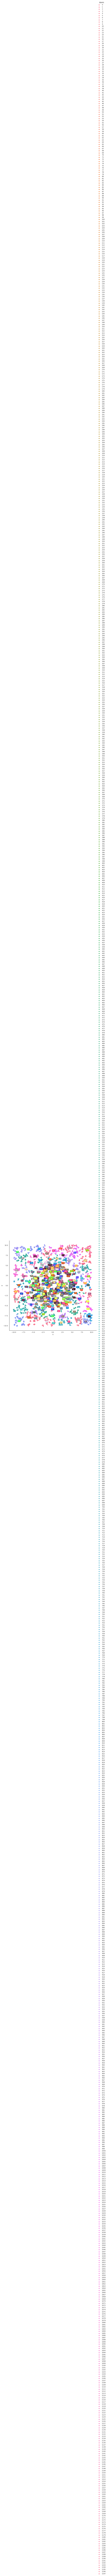

In [16]:
hyper_cluster(CLUSTER_ALGO)

In [17]:
Cottman
*-+
*+-=END

SyntaxError: invalid syntax (<ipython-input-17-f14960111e04>, line 2)